In [2]:
import numpy as np
import pandas as pd
import math
import yfinance
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
def rmse(predicted, actual):
    diffs = predicted - actual
    return math.sqrt(np.mean(diffs ** 2))

In [4]:
obs = np.array([1,2,3,4])
pred = np.array([1,4,8,5])

obs100 = 100*obs
pred100 = 100* pred
obs100


array([100, 200, 300, 400])

In [5]:
rmse1 = rmse(pred,obs)
rmse100 = rmse(pred100, obs100)
print(rmse1, rmse100)

2.7386127875258306 273.8612787525831


## B2 - AR AND MONTE CARLO SIMULATION


<AxesSubplot:>

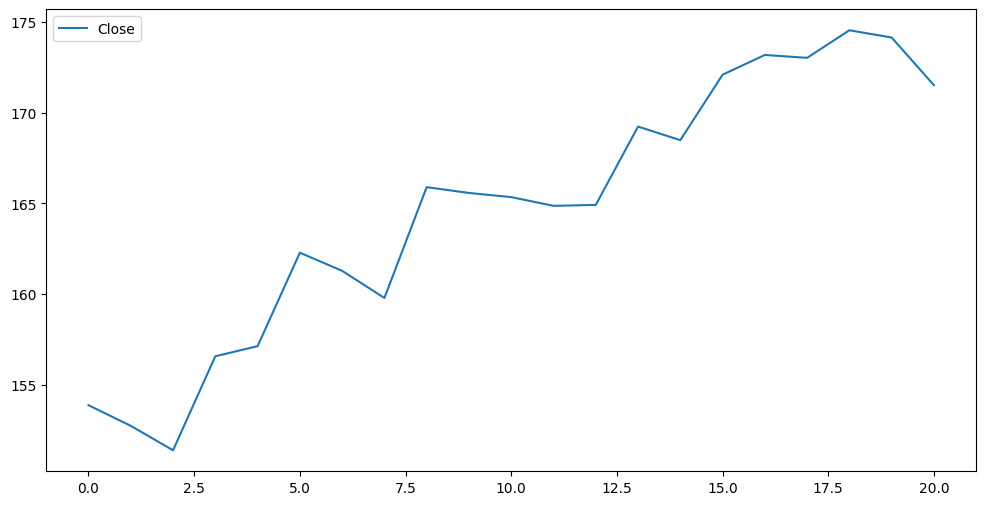

In [27]:
aapl = yfinance.Ticker('AAPL').history(start='2022-07-22', end='2022-08-22', interval='1d').reset_index()['Close'].to_frame()

plt.rcParams['figure.figsize'] = [12, 6]

aapl.plot()

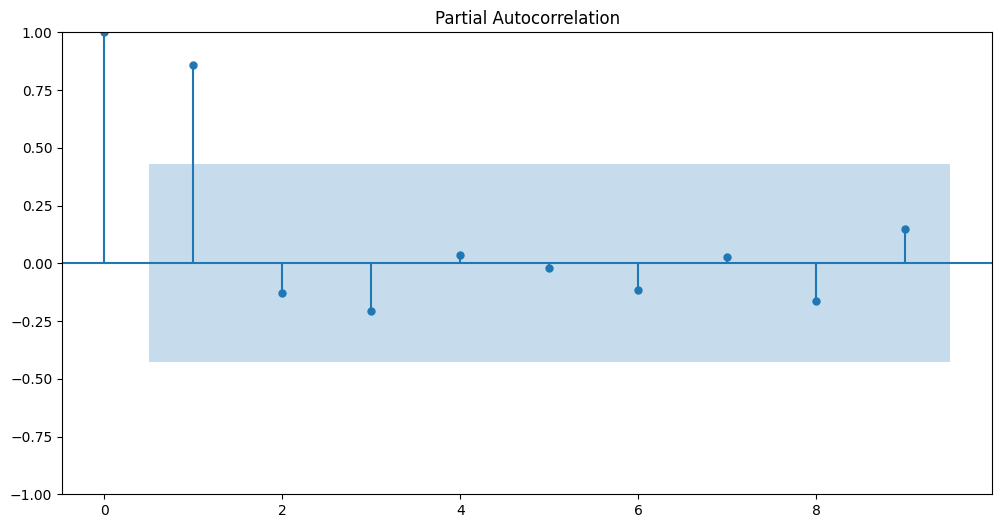

In [28]:
# plot pacf to determine appropriate amount of lags for AR(P)
series = aapl['Close']
series_log = np.log(series)
sm.graphics.tsa.plot_pacf(series, lags=9, method='ywm')
plt.show()


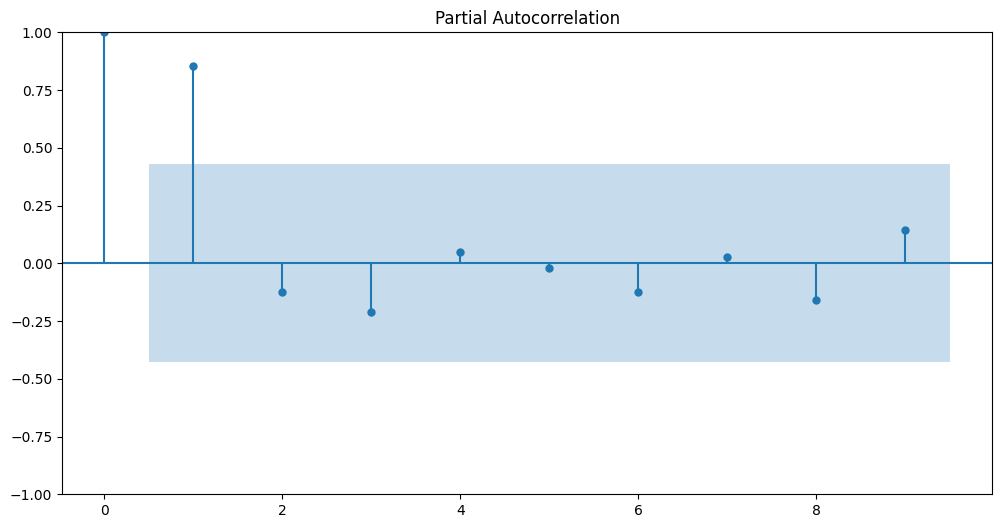

In [29]:
sm.graphics.tsa.plot_pacf(series_log, lags=9, method='ywm')
plt.show()

#### Choose AR(1) model

significant spike only at lag 1, meaning that all the higher-order autocorrelations are effectively explained by the lag-1 autocorrelation.

**SO DON'T CHOOSE AR(1) FOR WHATEVER REASON, JUST CHOOSE NEXT HIGHEST?**

### Check for stationarity - AD Fuller Test


In [8]:
adf_result = sm.tsa.stattools.adfuller(series)
print('p-value: ', adf_result[1])

p-value:  0.6633261578259837


p-value > 0.05 so not stationary - try differences

In [9]:
series_diff = (aapl['Close'] - aapl['Close'].shift()).dropna()
adf_result_shift = sm.tsa.stattools.adfuller(series_diff)
print('p-value: ', adf_result_shift[1])


p-value:  1.865355543968583e-06


p-value < 0.05 so now stationary

Try Pacf plot again

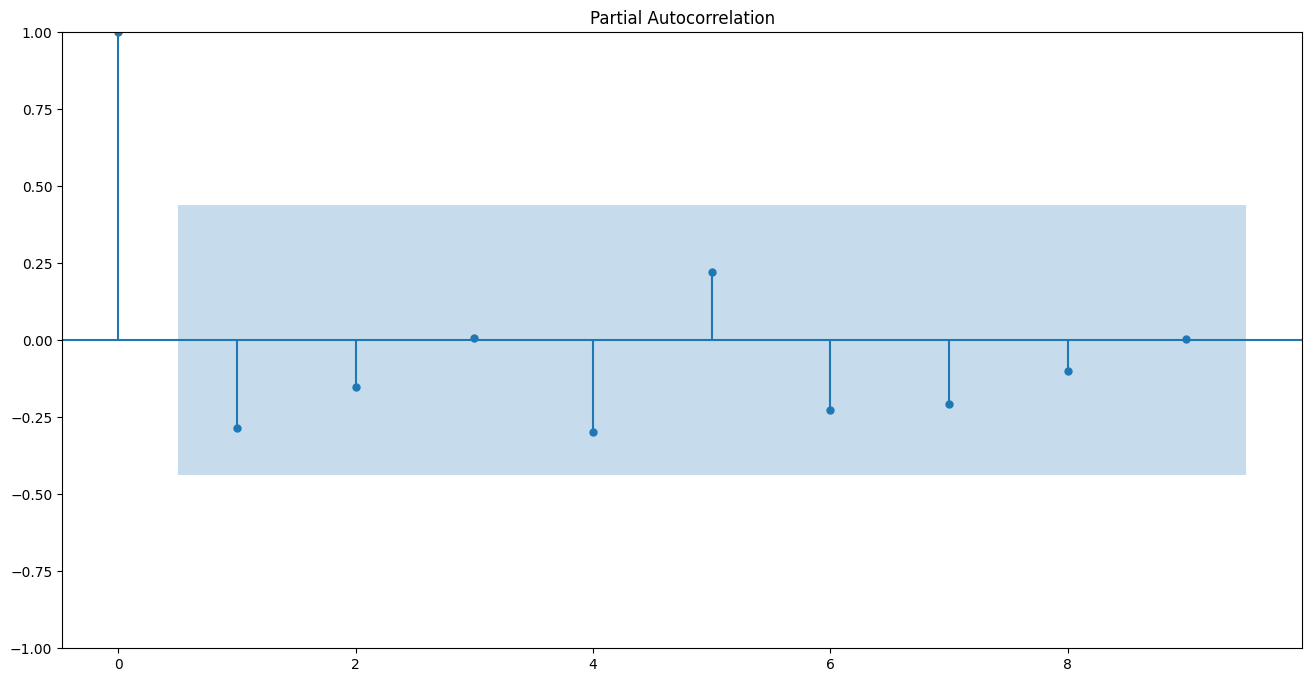

In [10]:
sm.graphics.tsa.plot_pacf(series_diff, lags=9, method='ywm')
plt.show()

## Run AR(1) MODEL AND COMPUTE RMSE

In [11]:
results = sm.tsa.AutoReg(series, 1, trend='n',).fit()
ar1_pred = results.predict()

ar1_rmse = np.sqrt(np.mean((ar1_pred - series) **2))
print('RMSE: ', ar1_rmse)


RMSE:  2.5118097294032746


In [12]:
coeffs = results.params
coeffs

Close.L1    1.005176
dtype: float64

## Monte Carlo

In [13]:
# number of trajectories to plot
num_samples = 100
# get last 10 values of the series as the common initial values of each trajectory
# convert them into 2d
initial_values = np.array(series[-10:]).reshape(1,-1)
print(initial_values.shape)

# create num_samples * initial values 2d array, will be the start of each trajectory
values = np.broadcast_to(initial_values, ( num_samples, 10))
print(values.shape)

(1, 10)
(100, 10)


In [14]:
ar_deg = 1

trajectory_length = 15

for i in range (trajectory_length):
    next_prediction = values[ : , -ar_deg : ] @ coeffs
    
    next_column = next_prediction + ar1_rmse * np.random.randn(num_samples)

    values = np.append(values, next_column.reshape( num_samples, 1), axis=1)




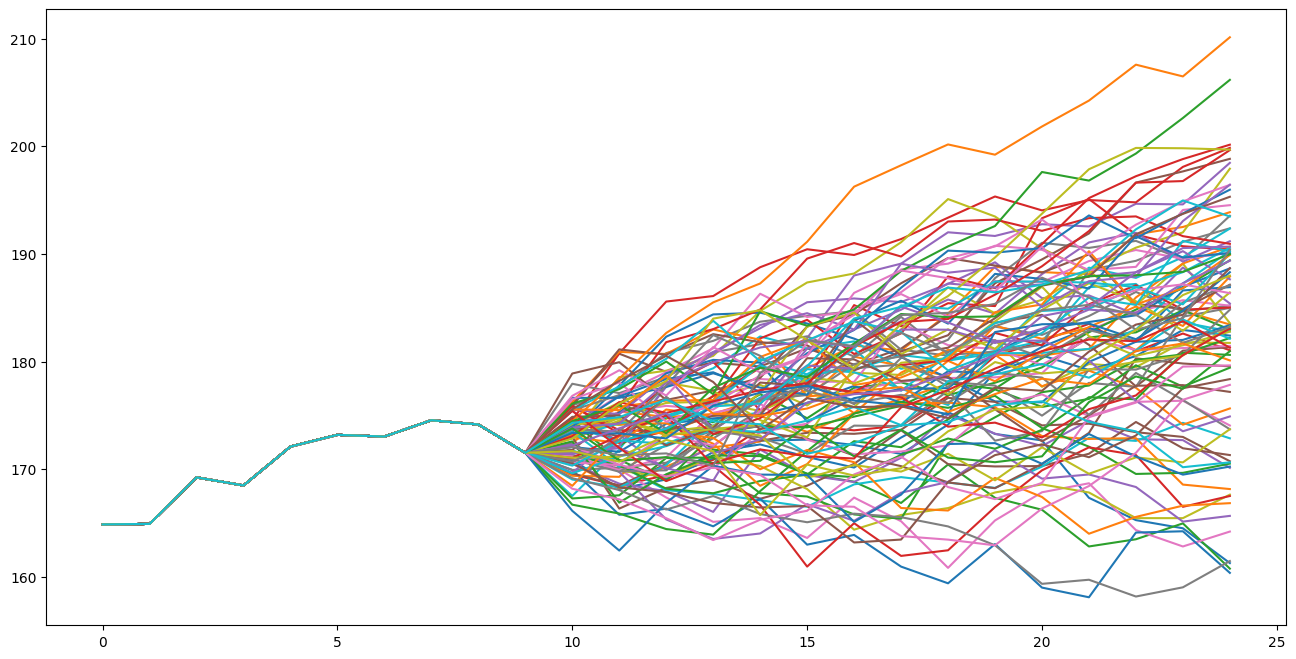

In [15]:
_=plt.plot(values.transpose())

In [16]:
def prob_above(values, marker):
    count = np.count_nonzero((values > marker))
    return count/values.size

def prob_below(values, marker):
    count = np.count_nonzero((values < marker))
    return count/values.size

def prob_between(values, low, high):
    count_low = np.count_nonzero((values < low))
    count_high = np.count_nonzero((values > high))
    return (values.size - count_low - count_high) / values.size

prob_above(next_column, 185)

0.5

# B3 ARCH & GARCH

In [17]:
temp_df = pd.read_csv('./data/temperatures.csv')
temp_df = temp_df[['LandAverageTemperature']].iloc[2500:3129]
# temp_df = temp_df.set_index('dt')
temp_df = temp_df.rename(columns={'LandAverageTemperature':'Observation'})
temp_df.head()

,Observation
2500,11.519
2501,13.187
2502,14.438
2503,13.597
2504,11.845


In [18]:
temp_df['Prediction'] = temp_df['Observation'].shift()
temp_df.head()

,Observation,Prediction
2500,11.519,NaN
2501,13.187,11.519
2502,14.438,13.187
2503,13.597,14.438
2504,11.845,13.597


In [19]:
temp_df['Error_sq'] = ((temp_df['Prediction'] - temp_df['Observation'])**2).fillna(0)
temp_df.head()

,Observation,Prediction,Error_sq
2500,11.519,NaN,0.000000
2501,13.187,11.519,2.782224
2502,14.438,13.187,1.565001
2503,13.597,14.438,0.707281
2504,11.845,13.597,3.069504


# ARCH MODEL

In [20]:
arch_deg = 4
garch_deg = 4

arch_model = sm.tsa.AutoReg(temp_df['Error_sq'], lags=arch_deg, trend='c').fit()
garch_model = sm.tsa.ARIMA(temp_df['Error_sq'], order = (4,0,4), trend='c').fit()



c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
garch_error_pred = np.sqrt(garch_model.predict())
temp_df['Garch_pred_error'] = garch_error_pred

temp_df['Garch Lower'] = temp_df['Prediction'] - temp_df['Garch_pred_error']
temp_df['Garch Upper'] = temp_df['Prediction'] + temp_df['Garch_pred_error']

temp_df.head(10)

c:\Users\hugho\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Observation,Prediction,Error_sq,Garch_pred_error,Garch Lower,Garch Upper
2500,11.519,NaN,0.000000,2.159970,NaN,NaN
2501,13.187,11.519,2.782224,1.922361,9.596639,13.441361
2502,14.438,13.187,1.565001,2.382788,10.804212,15.569788
2503,13.597,14.438,0.707281,2.694210,11.743790,17.132210
2504,11.845,13.597,3.069504,2.829078,10.767922,16.426078
2505,9.375,11.845,6.100900,2.502245,9.342755,14.347245
2506,6.260,9.375,9.703225,2.355707,7.019293,11.730707
2507,3.822,6.260,5.943844,1.723087,4.536913,7.983087
2508,2.959,3.822,0.744769,1.619327,2.202673,5.441327
2509,3.330,2.959,0.137641,1.710842,1.248158,4.669842


In [22]:
in_one_sd = (temp_df['Garch Upper'] > temp_df['Observation']) & \
    (temp_df['Garch Lower'] < temp_df['Observation'])

print("Percentage within 1 standard deviation", in_one_sd.mean() * 100)

in_two_sd = (temp_df['Prediction'] - 2 * temp_df['Garch_pred_error'] < temp_df['Observation']) & \
    (temp_df['Prediction'] + 2 * temp_df['Garch_pred_error'] > temp_df['Observation'])
print("Percentage within two standard deviations", in_two_sd.mean() * 100)

Percentage within 1 standard deviation 55.00794912559619
Percentage within two standard deviations 93.64069952305246


## LOG LIKELIHOOD

In [23]:
def log_likelihood(observation, prediction, predicted_errors):
    errors_sq = (observation - prediction) **2
    log_likelihoods = -np.log(predicted_errors) - 0.5 * errors_sq / predicted_errors **2 - 0.5 * np.log( 2 * np.pi)
    return np.sum(log_likelihoods)

def log_likelhood_avg(a,b,c):
    return log_likelihood(a,b,c) / len(a)



In [24]:
naive_rmse = rmse(temp_df['Observation'], temp_df['Prediction'])
naive_rmse

print('NAIVE LIKELIHOOD', log_likelhood_avg(temp_df['Observation'], temp_df['Prediction'], naive_rmse))

print('GARCH LIKELHIOOD', log_likelhood_avg(temp_df['Observation'], temp_df['Prediction'], temp_df['Garch_pred_error']))

NAIVE LIKELIHOOD -2.1850671737036174
GARCH LIKELHIOOD -2.410774285717742


# B4 - KALMAN FILTER AND VAR

Assume innacurate VAR model of two series - use Kalman filter to correct the VAR coefficients

2 series:
- GDP 
- Job Vacancies

Fit a VAR(2) model to the two of them   

* Will have 8 parameters
 


B4 Notes

Taking notes which are AR and doing VAR

to get vt use all that have v in second column

H will have lags

F identity matirx??